In [10]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

In [2]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

In [3]:
data

,name,origin,label,smiles,class
0,gamma-Aminobutyric acid,10.3390/molecules24152678,GABAA agonist,C(CC(=O)O)CN,1
1,Menthol,10.1111/bph.12602,GABAA agonist,CC1CCC(C(C1)O)C(C)C,1
2,phenobarbital,10.1002/ana.24967,GABAA agonist,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,1
3,isoguvacine oxide,10.1002/chir.530070608,GABAA agonist,C1CNCC2C1(O2)C(=O)O,1
4,Clomethiazole,10.1016/s0014-2999(02)02233-1,GABAA agonist,CC1=C(CCCl)SC=N1,1
...,...,...,...,...,...
483,chlorogenic acid,10.1021/jf0303971,GABAA inhibition,C1C(C(C(CC1(C(=O)O)O)OC(=O)C=CC2=CC(=C(C=C2)O)...,0
484,maltol,10.1021/jf0303971,GABAA inhibition,CC1=C(C(=O)C=CO1)O,0
485,Theobromine,10.1021/jf0303971,GABAA inhibition,CN1C=NC2=C1C(=O)NC(=O)N2C,0
486,"2,3,5-trimethylpyrazine",10.1021/jf0303971,GABAA inhibition,CN1C2=C(C(=O)N(C1=O)C)NC=N2,0


# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.CircularFingerprint(size=1024,radius=4)
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)

In [6]:
X_new.shape

(488, 870)

In [7]:
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [9]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=200)

# t-sne

D:\Miniconda\envs\bittersweet\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Miniconda\envs\bittersweet\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Axes: >

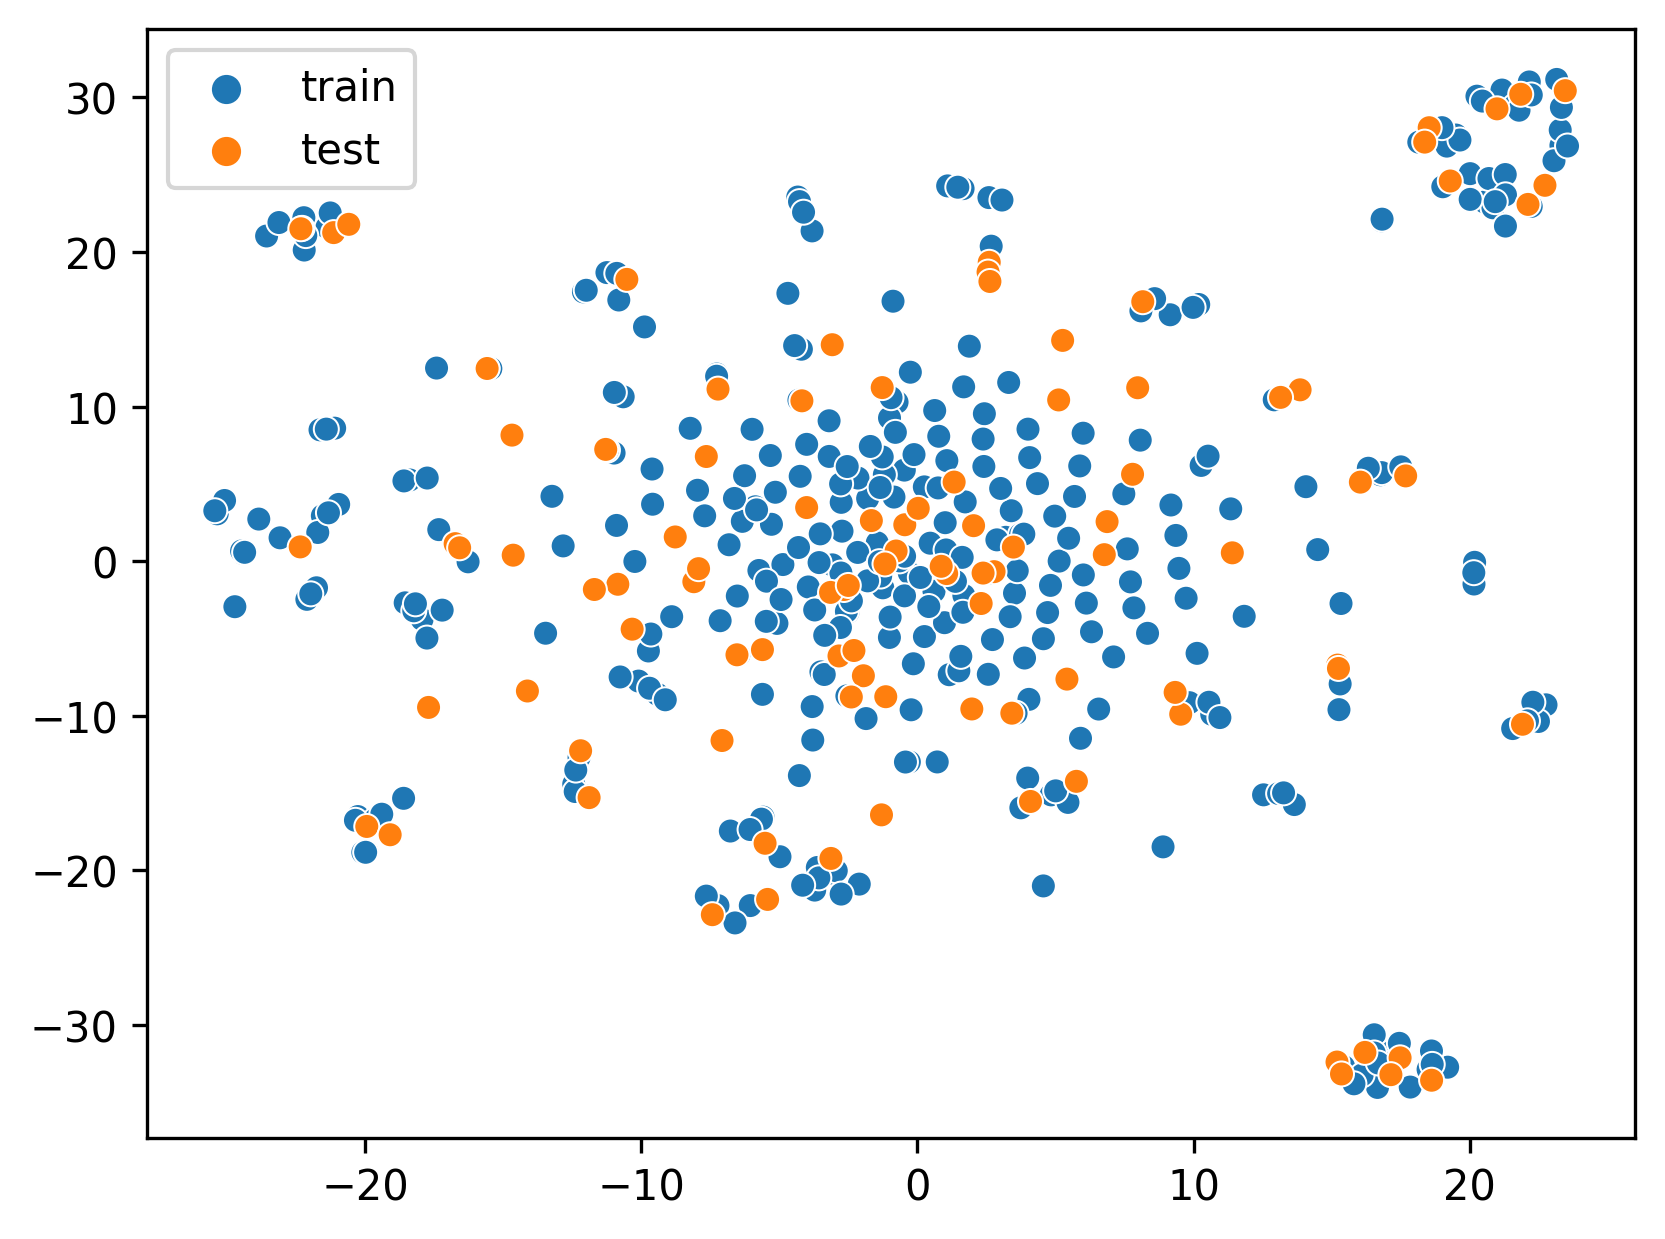

In [12]:
data_ecfp = np.concatenate((train_dataset.X, test_dataset.X), axis=0)

tsne = TSNE(n_components=2,random_state=42)
transformed_data = tsne.fit_transform(data_ecfp)


sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*390 + ['test']*98)

# GridSearchCV

In [14]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

classifier  =  RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators':[140,160,180,200,220,240],
              'max_depth':[5,10,20,30,40],
            'max_features':["auto", "sqrt", "log2"]}

rf_param_grid = {'n_estimators':[140],
              'max_depth':[5],
            'max_features':["sqrt", "log2"]}

rf_gs = GridSearchCV(
                    classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [15]:
val_AUC = rf_gs.best_score_
val_ACC = rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_]
val_PRE = rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_]
val_REC = rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_]

# GridSearchCV_Result

In [16]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (AUC): ', rf_gs.best_score_)
print('ACC: ', rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_])
print('PRE: ', rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_])
print('REC: ', rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 140}
Best score (AUC):  0.9137312976225622
ACC:  0.8205128205128206
PRE:  0.7924901185770751
REC:  0.8713537872935291


In [17]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=5, n_estimators=140, random_state=42)

# Evaluate model

In [18]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

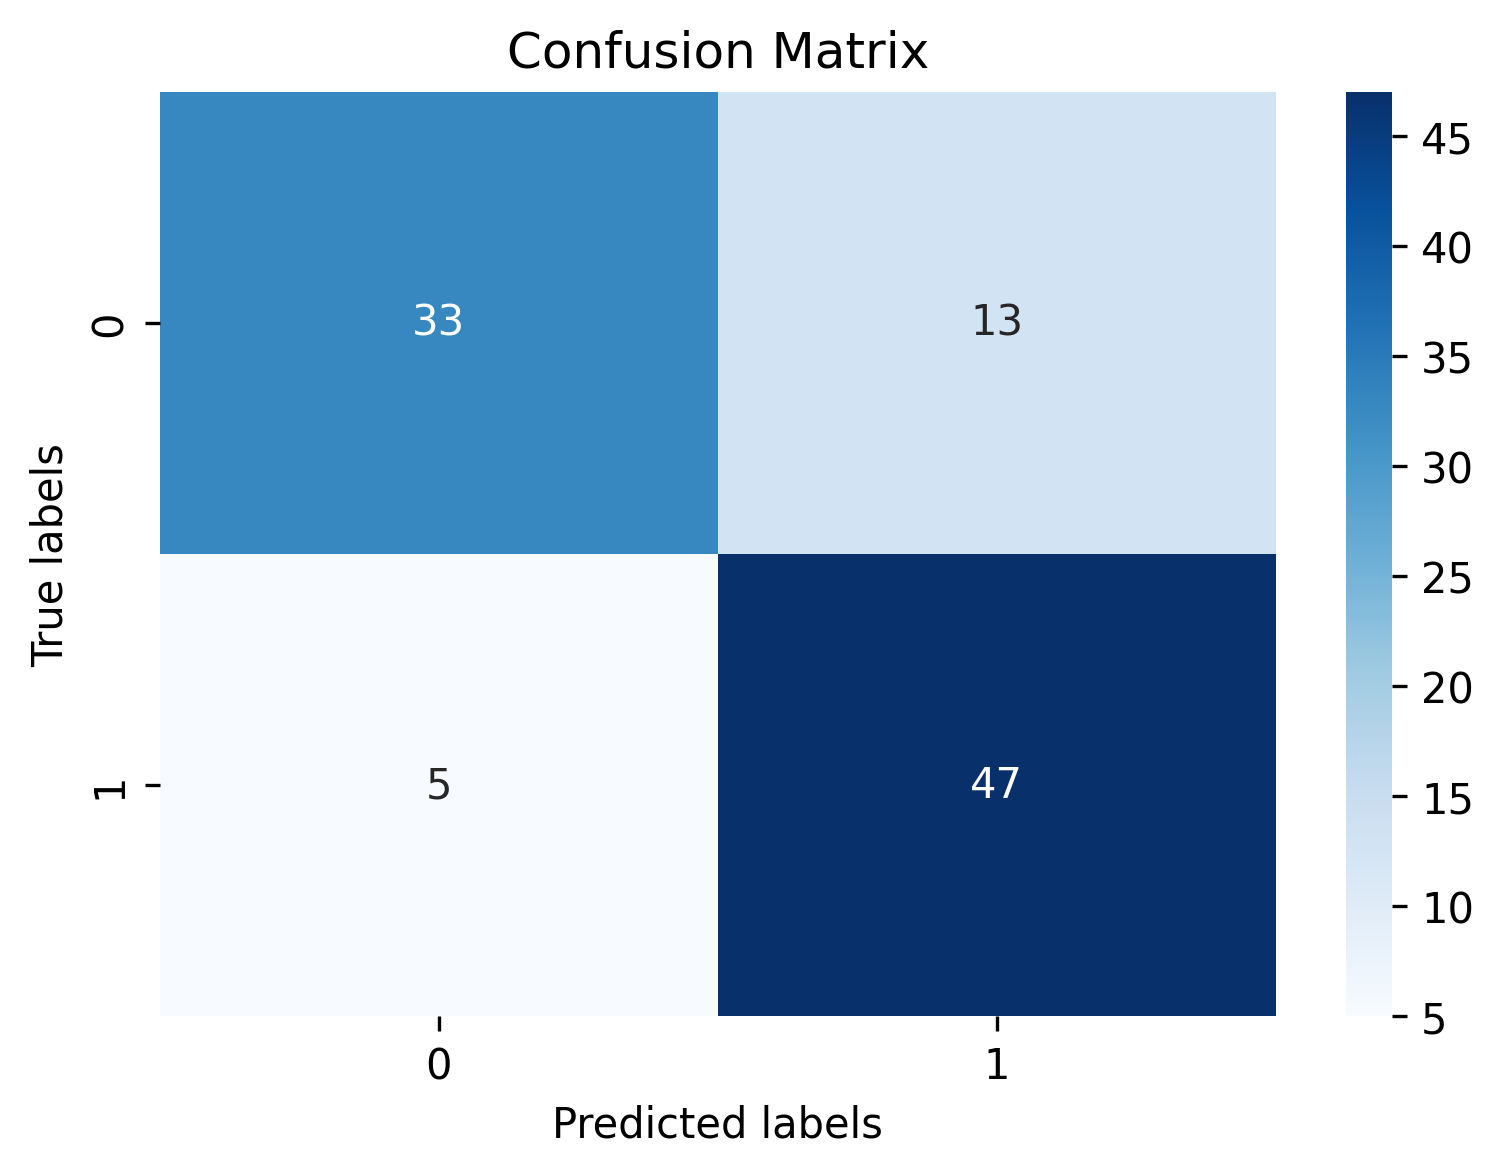

In [20]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [39]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [40]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [41]:
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(rf_test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(rf_test_pred_array))

# Finall result

In [42]:
rf_performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [43]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,AUC,ACC,PRE,REC
val,0.942687,0.853846,0.843333,0.870435
test,0.927676,0.867347,0.854545,0.903846
